This notebook creates a random uniform sample of N points within the bounds of a shapefile and outputs files to load into CEO for labeling.

In [1]:
# Import libraries
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Specify the number of points
n = 10

In [3]:
# Specify the path to the shapefile
shp = '/Users/hkerner/data/china/china_aoi_bounds/provinces/Provinces.shp'

In [4]:
# Specify the desired output file path
out_shp = 'random_sample_ceo_format.shp'

<AxesSubplot:>

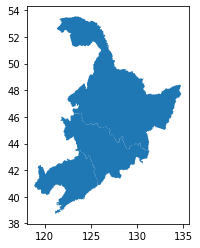

In [5]:
# Load the shapefile and plot the boundary
boundary = gpd.read_file(shp)
boundary.plot()

In [6]:
boundary

,ADM1_NAME,ADM0_NAME,Name,perimeter,area,geometry
0,Heilongjiang Sheng,China,Heilongjiang,5517851.752,4.482682e+10,"POLYGON ((123.38851 53.53572, 123.40188 53.534..."
1,Jilin Sheng,China,Jilin,3665255.203,1.916902e+10,"POLYGON ((123.97379 46.27779, 123.98667 46.240..."
2,Liaoning Sheng,China,Liaoning,3330468.127,1.466655e+10,"MULTIPOLYGON (((121.57840 39.18047, 121.57403 ..."


In [7]:
# Make sure the shapefile has EPSG:4326, otherwise convert it
print('Boundary shapefile CRS is %s' % boundary.crs)
if boundary.crs != 'epsg:4326':
    boundary = boundary.to_crs('epsg:4326')
    print('Boundary shapefile converted to %s' % boundary.crs)

Boundary shapefile CRS is epsg:4326


In [8]:
# Function for sampling random points. 
# From https://gis.stackexchange.com/questions/294394/randomly-sample-from-geopandas-dataframe-in-python
def random_points_in_polygon(num_points, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < num_points:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely points

In [9]:
# Sample n points within the shapefile
# Note: this assumes we want to sample N points within each shape/row in the shapefile/geodataframe
# Most shapefiles will likely only have one row if it is for a single region, but this allows us to
# stratify the samples by sub-regions if desired.
points = []
for i in range(boundary.shape[0]):
    points += random_points_in_polygon(n, boundary.iloc[i].geometry)

In [10]:
# Convert the list of points to a geodataframe
points_gdf = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(x=[p.x for p in points], 
                                                                  y=[p.y for p in points]))

<AxesSubplot:>

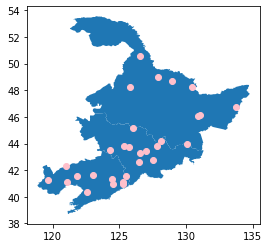

In [11]:
# Plot the random points
fig, ax = plt.subplots(1)
boundary.plot(ax=ax)
points_gdf.plot(ax=ax, color='pink')

In [12]:
# Add columns for CEO formatting
points_gdf['PLOTID'] = points_gdf.index
points_gdf['SAMPLEID'] = points_gdf.index

In [13]:
# Set the data type of the IDs to be integers
points_gdf['SAMPLEID'] = points_gdf['SAMPLEID'].astype(np.int64)
points_gdf['PLOTID'] = points_gdf['PLOTID'].astype(np.int64)

In [14]:
points_gdf

,geometry,PLOTID,SAMPLEID
0,POINT (128.98141 48.69101),0,0
1,POINT (127.93320 49.00728),1,1
2,POINT (130.06799 43.95006),2,2
3,POINT (130.44110 48.24944),3,3
4,POINT (130.86827 46.04898),4,4
5,POINT (126.54009 50.61003),5,5
6,POINT (125.99972 45.20296),6,6
7,POINT (125.77318 48.25872),7,7
8,POINT (131.08189 46.12811),8,8
9,POINT (133.73506 46.75883),9,9


In [15]:
points_gdf.crs = 'epsg:4326'

In [16]:
# Save the file as a new shapefile
points_gdf[['geometry', 'PLOTID', 'SAMPLEID']].to_file(out_shp, index=False)

# When creating the labeling project in CEO, use this file for 'Plot Design' and 'Sample Design' 
# (select SHP in the drop-down). You will need to zip the files before uploading.